# 🟡Step 0: Imports


**Most Relevant Papers** <br />
https://arxiv.org/pdf/1407.5675.pdf <br />
https://arxiv.org/pdf/1701.08784.pdf

In [1]:
#from utils import *

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display
import time

# Possibly Redundant
from scipy import ndimage, misc
from skimage.feature import peak_local_max
from skimage import data, img_as_float

%matplotlib inline

# 🟡Step 1: Read the data (tar.gz file)
As a first step, we unzipped the tar.gz file into a .dat file using 7-zip. 
Then, we convert the .dat file into a string and then into a DataFrame.

.strip() --> remove spaces on the sides

.split() --> separate values by spaces (otherwise we'd get a single conlumn)

In [2]:
# Convert .dat file into string (list comprehension)
datContent = [i.strip().split() for i in open("tth_semihad.dat").readlines()]

# Convert list into DataFrame
mydata = pd.DataFrame(datContent)

# 🟡Step 2: Explore the data
**Physics**

Jonas: "The file was produced from a simulation of pp->tt~H where the top decays hadronically
and the anti-top decays leptonically. <br /> I selected events with exactly 1 fat jet with R=1.5."


**Notes**
- The rows represent events (of 1 fat jet each, R = 1.5) 
- The first column represents the number of constituents of the jet  
- The following columns represent the coordinates of the constituents, η, φ, pT, cycling in that order. <br />(e.g. columns 1, 2, 3 are η, φ, pT for the 1st constituent, columns 4, 5, 6 are η, φ, pT for the 2nd constituent etc.)

<br />

- -infinity < η < infinity 
- -π < φ < π
- pT[GeV] > 0



In [3]:
# Display the data
mydata = mydata.rename(columns={0: 'Const'})
display(mydata.head())

# Print statements
events = mydata.shape[0]
print('There are {} rows (events).'.format(events))
print('The maximum number of constituents in an event is {}.'.format((mydata.shape[1] - 1) // 3))

# Display data types
#print('\nData Types: \n', mydata.dtypes)

# Descriptive statistics on data
#mydata.describe()

,Const,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,4,2.30474,0.221042,78.9436,1.00519,0.736657,61.9115,1.25546,0.748395,48.9755,...,None,None,None,None,None,None,None,None,None,None
1,2,2.35134,-2.18449,176.076,2.46233,-1.50073,47.3355,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,6,0.492933,0.766876,51.5247,-0.984489,2.29985,13.7463,0.103217,1.40088,5.31666,...,None,None,None,None,None,None,None,None,None,None
3,10,-0.624329,0.566723,130.197,-0.602316,0.573666,38.5226,-0.541426,0.449072,15.3244,...,None,None,None,None,None,None,None,None,None,None
4,15,-0.538961,-0.617644,0.819517,0.527734,1.53319,1.94989,0.20174,0.916744,5.63418,...,None,None,None,None,None,None,None,None,None,None


There are 12177 rows (events).
The maximum number of constituents in an event is 36.


#### 🔴 Mild Pre-Processing

1. Define function to separate constituents from coordinates, deal with NaN values, and convert values to floats.
2. Define processed dataframe and constituents vector

---

**Note: This is for testing only (displaying events throughout)**

In [6]:
def preprocessdf(df):
    '''
    -Extracts no. of constituents
    -Drops constituents column
    -Replaces NaN values with 0
    -Converts all values to floats
    
    Input: DataFrame to be transformed
    Output: Transformed DataFrame, constituents Series 
    '''
    
    # Create df copy
    df1 = df.copy(deep=True)
    
    # Extract constituents column
    const = df1['Const']
    # Drop constituents from df
    df1 = df1.drop('Const', axis=1)
    
    # Replace NaN with 0
    df1 = df1.fillna(0)

    # Convert values to floats
    df1 = df1.astype(float)
    
    return df1

In [8]:
# Define processed dataframe
mydata_prep = preprocessdf(mydata)

# 🟡Step 3: Construct Average Jet Image

**Jonas:**

The data in each row represents all the constituents of a fat jet in the original (φ,η,pT) coordinate system of the detector. 
You should now transform all the constituents of one fat jet (i.e. individually for each row in the data file) into a new coordinate system 
(φ',η’,pT). Consequently you transform/bin this information into a two-dimensional image/Heat Map.   

The steps in detail are

1. Find the constituent with the highest pT
2. Choose the center of the new coordinate system such that this constituent has the coordinates (φ’,η’)=0. This operation corresponds to rotating and boosting along the beam direction to center the jet.  
3. Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.
4. Flip all the constituents such that the constituents with the 3rd highest pT is on the right, i.e. at (φ’,η’)=(f,e) with f > 0
5. Define a 2-dim image with 40x40 pixels which correspond to η', φ' ∈ (−R, R). The jets we are looking at are approximately cone-shaped with radius R. I.e. all the constituents of the jet should end up within this image. For each pixel you now store the sum of the pT of all constituents that are located within this pixel. I.e. you discretise the (φ’,η’) coordinates into pixels and the intensity of the pixel corresponds to the sum of the energy of all constituents in the pixel.

As a very first step you can plot the images constructed from just steps 1)+2)+5) for a couple of jets. All the images will only have a few pixels filled. Subsequently you should plot the sum of all these images. This should give a broad peak at the center. 

Finally you should apply 1)-5) and plot the sum. This should hopefully look like the image from the reference. 



---
<br />

---
<br />

---
<br />

---
<br />

---

### 🔵 0. Define image creation functions

#### 🔴 Helper Function that creates an image of events

1. Bins η, φ, p
2. Creates Image using np.histogram2d(). pd.DataFrame(), sns.heatmap()

In [14]:
def create_image(df1, R=1.5, pixels=60):
    
    '''
    Displays an image of single event, or multiple events (input can be either Series or DataFrame). If DataFrame, then average image is created.  
    
    Input: dataframe (multiple events)
    Output: null, just plots image
    
    table: if df=True, then display the image as a DataFrame as well
    '''
    
    # Create copy of df so that it's not accidentally modified
    df = df1.copy(deep=True)
    
    # If input is Series (single event) then turn into DataFrame. This makes it so that single events are processed correctly
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df).T

    # Initiate bin lists
    bin_h = []
    bin_f = []
    bin_p = []

    # Define max number of constituents 
    max_const = df.shape[1] // 3

    # For all rows
    for i in range(df.shape[0]):             

        # For all constituents
        for j in range(max_const):
            # Add constituent's coordinates to bin lists
            bin_h.append(list(df.iloc[i][::3])[j])
            bin_f.append(list(df.iloc[i][1::3])[j])
            bin_p.append(list(df.iloc[i][2::3])[j])

    # Turn lists into Series
    bin_h = pd.Series(bin_h)
    bin_f = pd.Series(bin_f)
    bin_p = pd.Series(bin_p)

   # Define no. of bins
    bin_count = np.linspace(-R, R, pixels + 1)

    # Create bins from -R to R (using bins vector)
    bins = np.histogram2d(bin_h, bin_f, bins=bin_count, weights=bin_p)[0] # x and y are switch because when the bins were turned into a Series the shape[0] and shape[1] were switched

    # Convert to DataFrame
    bins = pd.DataFrame(bins)
    image = bins
    
    return image

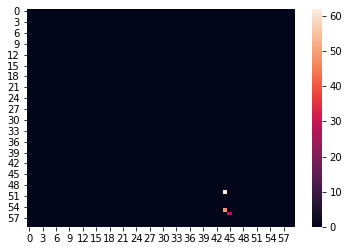

In [54]:
# Single Event Example using the first event
image1 = create_image(mydata_prep.iloc[0])
sns.heatmap(image1)
plt.show()

In [8]:
# # Multiple events example using unprocessed dataframe
# plot_events(mydata_prep, title='Unprocessed Image with R = 5', R=5, ylabel='η', xlabel='φ')

---
<br />

---
<br />

---
<br />

---
<br />

---

### 🔵 1. Extract Maxima
For each row, extract the maximum pT and its corresponding η and φ. <br />
We also extract the 2nd and 3rd maximum pT's for future use. 

---

#### 🔴 Define Helper Function that returns 3 vectors, one for each pT and its η, φ. (For the three maximum pT's)

- **1st vector**: 1st maximum pT and its η, φ
- **2nd vector**: 2nd maximum pT and its η, φ
- **3rd vector**: 3rd maximum pT and its η, φ

In [13]:
def extract_max123(event1):

    '''
    Input: event (row). 
    e.g. mydata_prep.iloc[0]

    Output[0]: [Series of 1st max p, φ, η]
    Output[1]: [Series of 2nd max p, φ, η]
    Output[2]: [Series of 3rd max p, φ, η]
    '''


    # Create event copy
    event = event1.copy(deep=True)

    # Separate η, φ, pT
    hdata = event[::3]
    fdata = event[1::3]
    pdata1 = event[2::3]



    # 1. Extract index of maximum pT
    maxid1 = pdata1.idxmax()
    maxlist1 = []

    # 2. Extract max η, φ, pT for event
    if pdata1.max() != 0:                                                                     # Brief explanation of if statement below)
        maxlist1.append([event.iloc[maxid1-1], event.iloc[maxid1-2], event.iloc[maxid1-3]])   # From event, add to list the max pT and its η, φ
    else:
        maxlist1.append([0., event.iloc[maxid1-2], event.iloc[maxid1-3]])                    # If max pT is 0, then add it as 0 and not the first value

    # 3. Create & Display dataframe of max pT, η, φ
    row_max1 = pd.Series(data=maxlist1[0], index=['pT', 'φ', 'η'])




    # 0. Set Max pT to 0 to find next Max pT
    pdata2 = pdata1.copy(deep=True)
    pdata2.loc[maxid1] = 0

    # 1. Extract index of maximum pT
    maxid2 = pdata2.idxmax()
    maxlist2 = []

    # 2. Extract max η, φ, pT for event
    if pdata2.max() != 0:                                                                     # Brief explanation of if statement below)
        maxlist2.append([event.iloc[maxid2-1], event.iloc[maxid2-2], event.iloc[maxid2-3]])   # From event, add to list the max pT and its η, φ
    else:
        maxlist2.append([0., event.iloc[maxid2-2], event.iloc[maxid2-3]])                    # If max pT is 0, then add it as 0 and not the first value

    # 3. Create & Display dataframe of max pT, η, φ
    row_max2 = pd.Series(data=maxlist2[0], index=['pT', 'φ', 'η'])




    # 0. Set Max pT to 0 to find next Max pT
    pdata3 = pdata2.copy(deep=True)
    pdata3.loc[maxid2] = 0

    # 1. Extract index of maximum pT
    maxid3 = pdata3.idxmax()
    maxlist3 = []

    # 2. Extract max η, φ, pT for event
    if pdata3.max() != 0:                                                                     # Brief explanation of if statement below)
        maxlist3.append([event.iloc[maxid3-1], event.iloc[maxid3-2], event.iloc[maxid3-3]])   # From event, add to list the max pT and its η, φ
    else:
        maxlist3.append([0., event.iloc[maxid3-2], event.iloc[maxid3-3]])                    # If max pT is 0, then add it as 0 and not the first value

    # 3. Create & Display dataframe of max pT, η, φ
    row_max3 = pd.Series(data=maxlist3[0], index=['pT', 'φ', 'η'])



    return row_max1, row_max2, row_max3

In [55]:
# # Example using first event
# extract_max123(mydata_prep.iloc[0])

**Why the if statement?** (note to self) <br />
Because if maximum pT is 0 in the pdata vector, it picks the ID of the first pT by default as the max (because they're all 0). <br />
Then, it goes to the non-zero'd event vector and adds its non-zero pT as the max, when the value of that max should clearly have been 0.

So the if statement fixes this: <br />
- If max pT != 0, then add it as normal.
- If max pT = 0, then add '0' as its value instead. (with the coordinates of the first pT, which is incorrect, but this doesn't matter since pT = 0 are not taken into account in the image) <br />


---

#### 🔴 Define list of 3 DataFrames containing the maxima (+ η, φ)

Note: Try this using the map() function instead

In [12]:
maxpt1 = []
maxpt2 = []
maxpt3 = []

start = time.time()

# For all events, add maxima to & coordinates to list
for i in range(events):
    maxpt1.append(extract_max123(mydata_prep.iloc[i])[0])
    maxpt2.append(extract_max123(mydata_prep.iloc[i])[1])
    maxpt3.append(extract_max123(mydata_prep.iloc[i])[2])
    
# Turn lists into DataFrames
max1 = pd.DataFrame(maxpt1)
max2 = pd.DataFrame(maxpt2)
max3 = pd.DataFrame(maxpt3)

# Create list of DataFrames containing all df for the 3 maxima
max123 = [max1, max2, max3]

end = time.time()
print('Time taken: {0:.2f}s'.format(end-start))

Time taken: 45.13s


In [ ]:
# Display max123 DataFrame
display(max123)

---
<br />

---
<br />

---
<br />

---
<br />

---

### 🔵2. Shift: Centre Image
For each row, we centre a new coordinate system so that the highest pT constituent's coordinates are (φ', η') = (0, 0). <br />
This corresponds to rotating and boosting along the beam direction to center the jet.

**φ Tranformation**<br />
For the φ transformation, we subtract the φ (of the max pT) from all φ's in that row. <br />
If the values exceed [-π, π], we add 2π to the final result (if it's <-π) or subtract 2π from the final result (if it's >π). This makes sure that no values exceed the original φ interval. <br />
This has the effect of making the φ (corresponding to the max pT for that row) equal to 0 in each row, and shifting the other φ's by that same angle, while maintaining a range of 2π. <br />

**η Transformation**<br />
How does η transform? We need a Lorentz Transformation. 

**Paper** (E) <br />
Histograms binned in
either the angular separation of events or the rapidity separation of events can
be contributed to by events whose centre of mass frames are boosted by arbitrary velocities with respect to the rest frame of the detector, the lab frame.
The resulting histograms are undistorted by these centre of mass frame boosts
parallel to the beam axis, as the dependent variable is invariant with respect
to this sub–class of Lorentz boosts.

**Paper** (F): make code cell below markdown to display


In [ ]:
#<img src="h1.png" width="500"> <img src="h2.png" width="500">

φ Only Example Comparison found in utils

## 🔴 **Centering Transformation** (η and φ)


#### 🔴 Helper Function

In [26]:
mydata_prep

0         4.0
1         2.0
2         6.0
3        10.0
4        15.0
         ... 
12172     9.0
12173    20.0
12174    10.0
12175     9.0
12176     8.0
Name: 0, Length: 12177, dtype: float64

In [11]:
mydata_prep.iloc[0][::3].index

Index([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,  40,
        43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,  79,  82,
        85,  88,  91,  94,  97, 100, 103, 106],
      dtype='object')

In [12]:
def center(event1, max123, output='event', R=1.5, pixels=60):
    
    '''
    Centers image around (φ', η') = (0, 0). Both transformations are linear (so far). 
    
    event1: the event (row) to be transformed
    max123: list of 3 dataframes of max pT, η, φ. Obtained using the extract_max123() function
    output: 'event' to return a Series of the transformed event1. 'image' to return a transformed dataframe representing an image 
    '''
    
    # Define η, φ indices to be used later
    h_indices = event1[::3].index
    f_indices = event1[1::3].index

    # Create copy of event
    event = event1.copy(deep=True)

    
    
    # For all η, φ in the event
    for h_index, f_index in zip(h_indices, f_indices):             

        # Define Useful Quantities
        num_index = event.name                   # index of event, so that we can find its corresponding φ in the max123[0] dataframe of max pT's and φ, η's
        maxh = max123[0].loc['η']                # η of max1 pT value
        maxf = max123[0].loc['φ']                # φ of max1 pT value
        f = event.iloc[1::3][f_index]            # φ original value
        
        # η Transformation
        event.iloc[::3][h_index] -= maxh         # Subtract max η from current η
        
        # φ Transformation (Note: the if statements take periodicity into account, making sure that range does not exceed 2π)
        if (f - maxf) < -np.pi:
            event.iloc[1::3][f_index] = f + 2*np.pi - maxf

        elif (f - maxf) > np.pi:
            event.iloc[1::3][f_index] = f - 2*np.pi - maxf

        else: 
            event.iloc[1::3][f_index] -= maxf     # Subtract max φ from current φ


    if output == 'event':
        return event
    
    
    
    
    elif output == 'image':
        # Initiate bin lists
        bin_h = []
        bin_f = []
        bin_p = []

        # Define max number of constituents 
        max_const = event.shape[0] // 3
        # For all constituents
        for i in range(max_const):
            # Add constituent's η, φ, p to bins
            bin_h.append(list(event.iloc[::3])[i])
            bin_f.append(list(event.iloc[1::3])[i])
            bin_p.append(list(event.iloc[2::3])[i])

        # Turn lists into Series
        bin_h = pd.Series(bin_h)
        bin_f = pd.Series(bin_f)
        bin_p = pd.Series(bin_p)

        # Define no. of bins
        bin_count = np.linspace(-R, R, pixels + 1)

        # Create bins from -R to R and convert to DataFrame
        bins = np.histogram2d(bin_h, bin_f, bins=bin_count, weights=bin_p)[0] # x and y are switch because when the bins were turned into a Series the shape[0] and shape[1] were switched
        bins = pd.DataFrame(bins)
        image = bins
        
        return image

In [ ]:
# Test with single event
e = 3
plot_events(mydata_prep.iloc[e], title='Before Centering', xlabel='φ', ylabel='η')
image=center(mydata_prep.iloc[e], max123, output='image')
sns.heatmap(image)
plt.title('After Centering')
plt.xlabel('φ\'')
plt.ylabel('η\'')
plt.show()

In [56]:
# center(mydata_prep.iloc[0], max123)

#### 🔴 Create Centered DataFrame

In [26]:
### φ, η transform all events
centered = []

start = time.time()

a=0
progress=0

# Create matrix of transformed events
for i in range(events):
    
    centered.append(center(mydata_prep.iloc[i], max123, output='event'))
    # Progress Report
    a += 1
    if a > 100:
        print('Progress: {0:.2f}%'.format(len(centered/range(events)))
        a = 0
    

end = time.time()

# Turn matrix into DataFrame
mydata_centered = pd.DataFrame(centered)

print('Time taken to centre image: {0:.2f}s'.format(end-start))

Time taken to centre image: 140.28s


In [ ]:
image40 = create_image(mydata_centered, R=1, pixels = 40)

In [44]:
image60 = create_image(mydata_centered, R=1, pixels = 60)

In [45]:
image80 = create_image(mydata_centered, R=1, pixels = 80)

In [46]:
image200 = create_image(mydata_centered, R=1, pixels = 200)
sns.heatmap(image40, robust=True)
plt.show()
sns.heatmap(image60, robust=True)
plt.show()
sns.heatmap(image80, robust=True)
plt.show()
sns.heatmap(image200, robust=True)
plt.show()

---

---

#### Read Large Dataset Pseudocode

In [22]:
ev = mydata.iloc[0]

In [23]:
ev.drop(ev.index[0])

1       2.30474
2      0.221042
3       78.9436
4       1.00519
5      0.736657
         ...   
104        None
105        None
106        None
107        None
108        None
Name: 0, Length: 108, dtype: object

In [25]:
def preprocess(event1):
    '''
    -Extracts no. of constituents
    -Drops constituents column
    -Replaces NaN values with 0
    -Converts all values to floats
    
    Input: Series (event) to be processed
    Output: Processed Series, constituents Series 
    '''
    
    # Create series copy
    event = event1.copy(deep=True)
    
    # Drop constituents from row
    event = event.drop(event.index[0])
    
    # Replace NaN with 0
    event = event.fillna(0)

    # Convert values to floats
    event = event.astype(float)
    
    return event

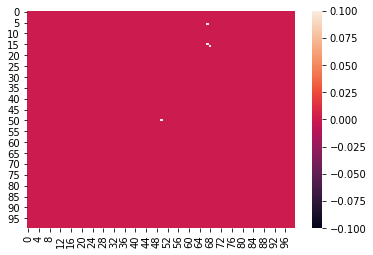

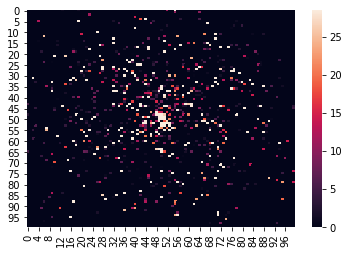

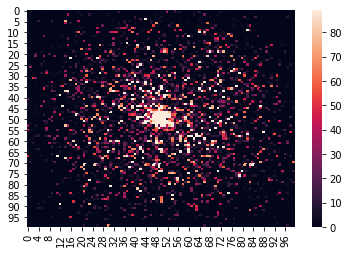

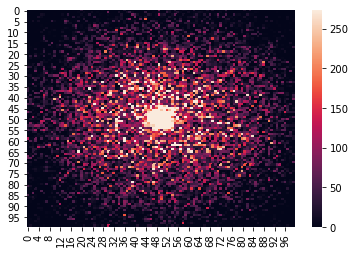

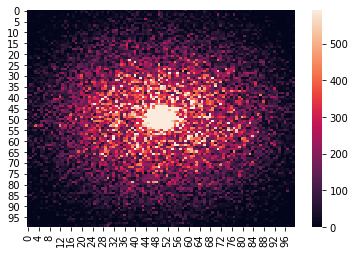

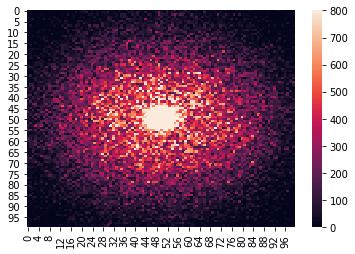

In [41]:
pixels = 100
frequency = [1, 100, 500, 3000, 8000, 12000]
image = np.zeros((pixels, pixels))
a = 0
with open("tth_semihad.dat") as infile:
    for line in infile:
        a += 1
        event=line.strip().split()
        event = pd.Series(event)                    # Turn into Series
        event = preprocess(event)                   # Preprocess
        max123 = extract_max123(event)              # Extract maxima
        event = center(event, max123)               # Center 
        #event = rotate(event, max123)              # Rotate 
        #event = flip(event, max123)                # Flip 
        event = create_image(event, pixels=pixels)  # Create image
        event = event.to_numpy()                    # Turn image to ndarray
        image += event                              # Add event image to average image
        event = max123 = None                       # Delete from memory
        if a in frequency:
            sns.heatmap(image, robust=True)
            plt.show()

---
<br />

---
<br />

---
<br />

---
<br />

---

### 🔵(Incomplete) 3. Rotation: Rotate image such that 2nd max pT is at 12 o'clock
Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.

**Paper (C)** <br />
"Rotation: Rotation is performed to remove the stochastic nature of the decay
angle relative to the η − φ coordinate system. This alignment can be done very
generally, by determining the principle axis [48] of the original image and rotating the imagine around the jet-energy centroid such that the principle axis
is always vertical."

#### Resources
https://stackoverflow.com/questions/53854066/pythonhow-to-rotate-an-image-so-that-a-feature-becomes-vertical

https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

https://pythontic.com/image-processing/pillow/rotate

https://www.askpython.com/python/examples/rotate-an-image-by-an-angle-in-python

https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/




---
<br />

---
<br />

---
<br />

---
<br />

---

### 🔵(Incomplete) 4. Flip: Flip image so that 3rd max pT is in right-half plane
Flip all the constituents such that the constituents with the 3rd highest pT is on the right, i.e. at (φ’,η’)=(f,e) with f > 0

---
<br />

---
<br />

---
<br />

---
<br />

---

### 🔵5. Image: Create 40x40 Image
1. Define Data that will create the bins (η, φ) and will weigh the bins (pT)
2. Using the bins, create a 2D histogram using numpy's histogram2d()
3. Input the histogram as a DataFrame into Seaborn's heatmap()
4. Tadaaaa


---

#### 🔴 Old code to check if bins are crated correctly

In [ ]:
# Test if bin lengths match
if (len(bin_h) == len(bin_f)) and (len(bin_f) == len(bin_p)):
    print('\nSuccess: Bin lengths match! :D')
else:
    print('\nError: Bin lengths don\'t match!!! :  -  (')
    assert (len(bin_h) == len(bin_f)) and (len(bin_f) == len(bin_p))

# Test if max and min values make sense
print('\nη bin range: [', round(min(bin_h), 2), ', ', round(max(bin_h), 2), ']')
print('φ bin range: [', round(min(bin_f), 2), ', ', round(max(bin_f), 2), ']')
print('p bin range: [', round(min(bin_p), 2), ', ', round(max(bin_p), 2), ']')

---

---

---